In [147]:
!gdown 1dOMvfqa-63c_lOuIIo_kb5xILvI6REaa

Downloading...
From: https://drive.google.com/uc?id=1dOMvfqa-63c_lOuIIo_kb5xILvI6REaa
To: /content/photo1.png
100% 2.07M/2.07M [00:00<00:00, 108MB/s]


In [148]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import cv2
import math

In [149]:
img = cv2.imread('photo1.png')
yCrCbImg = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)

In [150]:
yCrCbImg.shape

(853, 1280, 3)

In [151]:
img_downSampled_cr = cv2.pyrDown(yCrCbImg[:,:,1])
img_downSampled_cb = cv2.pyrDown(yCrCbImg[:,:,2])
img_y = yCrCbImg[:,:,0]
downSampled_img = [img_y, img_downSampled_cr, img_downSampled_cb]

In [152]:
block_size = 8

QUANTIZATION_MAT = np.array([[16,11,10,16,24,40,51,61],[12,12,14,19,26,58,60,55],[14,13,16,24,40,57,69,56 ],[14,17,22,29,51,87,80,62],[18,22,37,56,68,109,103,77],[24,35,55,64,81,104,113,92],[49,64,78,87,103,121,120,101],[72,92,95,98,112,100,103,99]])

In [153]:
import pickle

class NodeTree(object):
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right

    def children(self):
        return (self.left, self.right)

    def nodes(self):
        return (self.left, self.right)

    def __str__(self):
        return '{}_{}'.format(self.left, self.right)

def huffman_code_tree(node, left=True, binString=''):
    if type(node) is str:
        return {node: binString}

    (l, r) = node.children()
    d = dict()
    d.update(huffman_code_tree(l, True, binString + '0'))
    d.update(huffman_code_tree(r, False, binString + '1'))
    return d

def make_tree(symbols_array, fileName):

  # Calculating 
  freq = {}
  for c in symbols_array:
      c = str(c)
      if c in freq:
          freq[c] += 1
      else:
          freq[c] = 1

  freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)

  nodes = freq

  while len(nodes) > 1:
      (key1, c1) = nodes[-1]
      (key2, c2) = nodes[-2]
      nodes = nodes[:-2]
      node = NodeTree(key1, key2)
      nodes.append((node, c1 + c2))

      nodes = sorted(nodes, key=lambda x: x[1], reverse=True)

  huffmanCode = huffman_code_tree(nodes[0][0])

  tree_dict = {}
  for (char, frequency) in freq:
      tree_dict[int(float(char))] = huffmanCode[char]

  with open('{}.pkl'.format(fileName), 'wb') as f:
    pickle.dump(tree_dict, f)

  return tree_dict

In [154]:
def get_run_length_encoding(image):
    i = 0
    skip = 0
    stream = []    
    bitstream = ""
    image = image.astype(int)
    while i < image.shape[0]:
        if image[i] != 0:            
            stream.append((image[i],skip))
            bitstream = bitstream + str(image[i])+ " " +str(skip)+ " "
            skip = 0
        else:
            skip = skip + 1
        i = i + 1

    return bitstream

In [163]:
def get_huffman_encoding(image, fileName):
  tree = make_tree(image, fileName)
  image = image.astype(int)
  newFile = ""
  i = 0
  while i < image.shape[0]:
    newFile = newFile + tree[image[i]]
    i = i + 1

  file1 = open("huffman-{}.txt".format(fileName),"w")
  file1.write(newFile)
  file1.close()

In [156]:
def zigzag(input):
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    vmax = input.shape[0]
    hmax = input.shape[1]
    
    i = 0

    output = np.zeros(( vmax * hmax))

    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:
            if (v == vmin):
                output[i] = input[v, h]

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        

                i = i + 1

            elif ((h == hmax -1 ) and (v < vmax)):
            	output[i] = input[v, h] 
            	v = v + 1
            	i = i + 1

            elif ((v > vmin) and (h < hmax -1 )):
            	output[i] = input[v, h] 
            	v = v - 1
            	h = h + 1
            	i = i + 1
        
        else:
        	if ((v == vmax -1) and (h <= hmax -1)):
        		output[i] = input[v, h] 
        		h = h + 1
        		i = i + 1
        
        	elif (h == hmin):
        		output[i] = input[v, h] 

        		if (v == vmax -1):
        			h = h + 1
        		else:
        			v = v + 1

        		i = i + 1

        	elif ((v < vmax -1) and (h > hmin)):
        		output[i] = input[v, h] 
        		v = v + 1
        		h = h - 1
        		i = i + 1

        if ((v == vmax-1) and (h == hmax-1)):
        	output[i] = input[v, h] 
        	break

    return output

In [157]:
def inverse_zigzag(input, vmax, hmax):
	h = 0
	v = 0

	vmin = 0
	hmin = 0

	output = np.zeros((vmax, hmax))

	i = 0
	while ((v < vmax) and (h < hmax)): 
		if ((h + v) % 2) == 0:
            
			if (v == vmin):
				output[v, h] = input[i]
				if (h == hmax):
					v = v + 1
				else:
					h = h + 1                        

				i = i + 1
			elif ((h == hmax -1 ) and (v < vmax)):
				output[v, h] = input[i] 
				v = v + 1
				i = i + 1

			elif ((v > vmin) and (h < hmax -1 )):
				output[v, h] = input[i] 
				v = v - 1
				h = h + 1
				i = i + 1

        
		else:           

			if ((v == vmax -1) and (h <= hmax -1)):    
				output[v, h] = input[i] 
				h = h + 1
				i = i + 1
        
			elif (h == hmin):  
				output[v, h] = input[i] 
				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1
				i = i + 1
        		        		
			elif((v < vmax -1) and (h > hmin)): 
				output[v, h] = input[i] 
				v = v + 1
				h = h - 1
				i = i + 1

		if ((v == vmax-1) and (h == hmax-1)): 
			output[v, h] = input[i] 
			break

	return output

In [158]:
def compressWithDct(img, fileName):
  [h , w] = img.shape

  height = h
  width = w
  h = np.float32(h) 
  w = np.float32(w) 

  nbh = math.ceil(h/block_size)
  nbh = np.int32(nbh)

  nbw = math.ceil(w/block_size)
  nbw = np.int32(nbw)

  H =  block_size * nbh
  W =  block_size * nbw

  padded_img = np.zeros((H,W))

  padded_img[0:height,0:width] = img[0:height,0:width]

  for i in range(nbh):

        row_ind_1 = i*block_size                
        row_ind_2 = row_ind_1+block_size

        for j in range(nbw):

            col_ind_1 = j*block_size                       
            col_ind_2 = col_ind_1+block_size
                        
            block = padded_img[ row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2 ]
                       
            DCT = cv2.dct(block)            

            DCT_normalized = np.divide(DCT,QUANTIZATION_MAT).astype(int)  

            reordered = zigzag(DCT_normalized)

            reshaped= np.reshape(reordered, (block_size, block_size)) 
            
            padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2] = reshaped                      

  arranged = padded_img.flatten()

  huffman_coded = get_huffman_encoding(arranged, fileName)

  bitstream = get_run_length_encoding(arranged)

  bitstream = str(padded_img.shape[0]) + " " + str(padded_img.shape[1]) + " " + bitstream + ";"

  file1 = open("{}.txt".format(fileName),"w")
  file1.write(bitstream)
  file1.close()


In [159]:
def encodeColoredImg(img):
  y = compressWithDct(img[0], 'y')
  cr = compressWithDct(img[1], 'cr')
  cb = compressWithDct(img[2], 'cb')

In [160]:
def deCompressWithDct(fileName):
  with open('{}.txt'.format(fileName), 'r') as myfile:
      image=myfile.read()

  details = image.split()

  h = int(''.join(filter(str.isdigit, details[0])))
  w = int(''.join(filter(str.isdigit, details[1])))

  array = np.zeros(h*w).astype(int)

  k = 0
  i = 2
  x = 0
  j = 0

  while k < array.shape[0]:
      if(details[i] == ';'):
          break
      if "-" not in details[i]:
          array[k] = int(''.join(filter(str.isdigit, details[i])))        
      else:
          array[k] = -1*int(''.join(filter(str.isdigit, details[i])))        

      if(i+3 < len(details)):
          j = int(''.join(filter(str.isdigit, details[i+3])))

      if j == 0:
          k = k + 1
      else:                
          k = k + j + 1        

      i = i + 2

  array = np.reshape(array,(h,w))

  i = 0
  j = 0
  k = 0

  padded_img = np.zeros((h,w))

  while i < h:
      j = 0
      while j < w:        
          temp_stream = array[i:i+8,j:j+8]                
          block = inverse_zigzag(temp_stream.flatten(), int(block_size),int(block_size))            
          de_quantized = np.multiply(block,QUANTIZATION_MAT)                
          padded_img[i:i+8,j:j+8] = cv2.idct(de_quantized)        
          j = j + 8        
      i = i + 8

  padded_img[padded_img > 255] = 255
  padded_img[padded_img < 0] = 0

  return padded_img


In [161]:
def decodeColoredImg():
  y = deCompressWithDct('y')
  half_cr = deCompressWithDct('cr')
  half_cb = deCompressWithDct('cb') 

  cr = cv2.pyrUp(half_cr)[:y.shape[0],:y.shape[1]]
  cb = cv2.pyrUp(half_cb)[:y.shape[0],:y.shape[1]]
  
  im = np.zeros((y.shape[0],y.shape[1],3))
  im[:,:,0] = y
  im[:,:,1] = cb
  im[:,:,2] = cr

  xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
  rgb = im.astype(float)
  rgb[:,:,[1,2]] -= 128
  rgb = rgb.dot(xform.T)
  np.putmask(rgb, rgb > 255, 255)
  np.putmask(rgb, rgb < 0, 0)

  rgb = np.uint8(rgb)
  cv2.imwrite('newPhoto1.png', rgb)
  plt.figure(figsize=(15,7))
  plt.imshow(rgb)


In [162]:
encodeColoredImg(downSampled_img)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp y.txt "/content/gdrive/My Drive/Multimedia/HW3"
!cp cr.txt "/content/gdrive/My Drive/Multimedia/HW3"
!cp cb.txt "/content/gdrive/My Drive/Multimedia/HW3"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# run if using huffman
!cp y.pkl "/content/gdrive/My Drive/Multimedia/HW3"
!cp cr.pkl "/content/gdrive/My Drive/Multimedia/HW3"
!cp cb.pkl "/content/gdrive/My Drive/Multimedia/HW3"

!cp huffman-y.txt "/content/gdrive/My Drive/Multimedia/HW3"
!cp huffman-cr.txt "/content/gdrive/My Drive/Multimedia/HW3"
!cp huffman-cb.txt "/content/gdrive/My Drive/Multimedia/HW3"

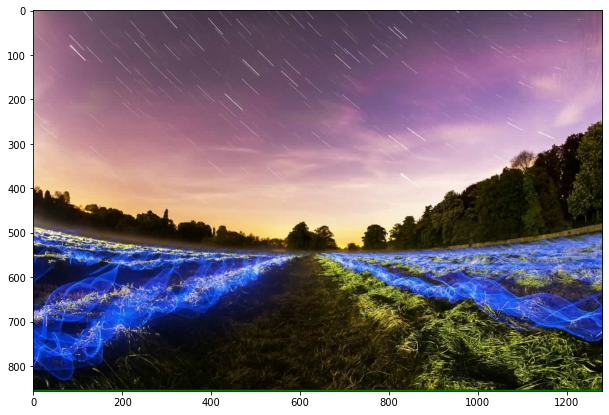

In [ ]:
decodeColoredImg()

In [165]:
import os
print('first photo: ', os.stat('photo1.png').st_size)
print('sent photo: ',os.stat('newPhoto1.png').st_size)
print('rlc compressed photo:',os.stat('y.txt').st_size + os.stat('cr.txt').st_size + os.stat('cb.txt').st_size)

first photo:  2069007
sent photo:  1396923
rlc compressed photo: 614650
